In [26]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib import ticker
from pathlib import Path
from DDACSDataset import DDACSDataset
from utils_DDACS import extract_mesh, extract_point_springback

# Config
OPERATION   = 10                    
TIMESTEP    = 2                    
sample_id   = "20134"              
pred_dir    = "/home/RUS_CIP/st186731/research_project/hybrid_approach/grit_like_and_graphormer_like/prediction/ddacs-node-regression/grit_like"
# pred_dir    = "/home/RUS_CIP/st186731/research_project/hybrid_approach/grit_like_and_graphormer_like/prediction/ddacs-node-regression/graphormer_like"
data_root   = "/mnt/ac142464/data/jiang"     
data_dir    = Path("/mnt/ac142464/data/darus/")

FIGURE_SIZES = {
    "double_col": (7.0, 3.0),
}
FIGURE_SIZE = FIGURE_SIZES["double_col"]
FIGURE_DPI = 150
AXIS_LIMITS = [0, 110]
VIEW_ELEVATION = 30
VIEW_AZIMUTH = 45

def find_h5_by_id(dataset, sid):
    """Return (sim_id, metadata, h5_path) for the given string/int sample id."""
    sid = str(sid)
    for i in range(len(dataset)):
        sim_id, meta, h5_path = dataset[i]
        if str(sim_id) == sid:
            return sim_id, meta, h5_path
    raise FileNotFoundError(f"Sample id {sid} not found in dataset")

def add_colorbar(fig, ax, mappable, label):
    cbar = fig.colorbar(mappable, ax=ax, shrink=0.8)
    cbar.ax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%.2f"))
    cbar.set_label(label, fontsize=11)

# Load dataset + files
dataset = DDACSDataset(data_dir, "h5")
print(f"Loaded {len(dataset)} simulations")

sim_id, metadata, h5_path = find_h5_by_id(dataset, sample_id)
print(f"Using sample {sim_id} → {h5_path}")
print(f"Metadata: {metadata}")

# Mesh 
node_coords, triangles = extract_mesh(
    h5_path, operation=OPERATION, component='blank', timestep=TIMESTEP
)  # node_coords: (N,3)

# Original springback
final_coords_gt, disp_gt = extract_point_springback(h5_path, operation=OPERATION)

# Predicted springback 
pred_path = os.path.join(pred_dir, f"{sample_id}_pred_node_displacement.npy")
disp_pred = np.load(pred_path)  

# Compute magnitudes 
mag_gt   = np.linalg.norm(disp_gt,   axis=1)  # [mm] np.linalg.norm(..., axis=1) takes the Euclidean (L2) norm row-wise
mag_pred = np.linalg.norm(disp_pred, axis=1)  # [mm]
difference_vector  = disp_pred - disp_gt
difference_mag  = np.linalg.norm(difference_vector, axis=1)  # [mm] absolute L2 error per node

# Basic stats
print("\n--- Springback stats ---")
print(f"Ground_Truth    : mean={mag_gt.mean():.4f},  max={mag_gt.max():.4f},  std={mag_gt.std():.4f}")
print(f"Prediction  : mean={mag_pred.mean():.4f}, max={mag_pred.max():.4f}, std={mag_pred.std():.4f}")
print(f"Difference : mean={difference_mag.mean():.4f},  max={difference_mag.max():.4f},  std={difference_mag.std():.4f}")

# All panels plotted at the same coordinates (GT final coords) for easy comparison.
# If undeformed mesh: use coords_plot = node_coords
# If predicted final pose: use coords_plot = node_coords + disp_pred
coords_plot = node_coords + disp_gt  

# plotting with existing routine
global_springback_min = 0.0
global_springback_max = 1.4
norm = Normalize(vmin=global_springback_min, vmax=global_springback_max)
global_springback_min_difference = 0.0
global_springback_max_difference = 0.3
norm_difference = Normalize(vmin=global_springback_min_difference, vmax=global_springback_max_difference) 


fig = plt.figure(figsize=(FIGURE_SIZE[0]*1.6, FIGURE_SIZE[1]), dpi=FIGURE_DPI)

# Create color
col1  = plt.cm.plasma(norm(mag_gt))
col2  = plt.cm.plasma(norm(mag_pred))
col3  = plt.cm.viridis(norm_difference(difference_mag))

# threshold = 0.1  # mm
# bright_color = np.array([1,0,0,1])  

# col1[mag_gt < threshold] = bright_color
# col2[mag_pred < threshold] = bright_color
# col3[difference_mag > threshold] = bright_color

# # colorbar-specific colormaps & norms so the bar shows the bright under-range
# cmap_plasma_cb  = plt.cm.get_cmap("plasma").copy()
# cmap_viridis_cb = plt.cm.get_cmap("viridis").copy()
# cmap_plasma_cb.set_under(bright_color)
# cmap_viridis_cb.set_under(bright_color)

# norm_cb        = Normalize(vmin=threshold, vmax=global_springback_max)
#norm_diff_cb   = Normalize(vmin=threshold, vmax=global_springback_max_difference)
# norm_diff_cb   = Normalize(vmin=0, vmax=threshold)

# Figure 1: Original magnitude 
ax1 = fig.add_subplot(131, projection="3d")
p1 = ax1.scatter(coords_plot[:,0], coords_plot[:,1], coords_plot[:,2], c=col1, s=1, alpha=0.9)
add_colorbar(fig, ax1, plt.cm.ScalarMappable(cmap="plasma", norm=norm), "Magnitude [mm]")
# add_colorbar(fig, ax1, plt.cm.ScalarMappable(cmap=cmap_plasma_cb, norm=norm_cb), "Magnitude [mm]")
ax1.set_title(f"Original Springback\n(OP{OPERATION}, id={sim_id})")
ax1.set_xlim(AXIS_LIMITS); ax1.set_ylim(AXIS_LIMITS); ax1.set_zlim(AXIS_LIMITS)
ax1.view_init(VIEW_ELEVATION, VIEW_AZIMUTH)
ax1.set_xlabel("X [mm]"); ax1.set_ylabel("Y [mm]"); ax1.set_zlabel("Z [mm]")

# Figure 2: Pred magnitude 
ax2 = fig.add_subplot(132, projection="3d")

p2 = ax2.scatter(coords_plot[:,0], coords_plot[:,1], coords_plot[:,2], c=col2, s=1, alpha=0.9)
add_colorbar(fig, ax2, plt.cm.ScalarMappable(cmap="plasma", norm=norm), "Magnitude [mm]")
# add_colorbar(fig, ax2, plt.cm.ScalarMappable(cmap=cmap_plasma_cb, norm=norm_cb), "Magnitude [mm]")
ax2.set_title(f"Predicted Springback\n(OP{OPERATION}, id={sim_id})")
ax2.set_xlim(AXIS_LIMITS); ax2.set_ylim(AXIS_LIMITS); ax2.set_zlim(AXIS_LIMITS)
ax2.view_init(VIEW_ELEVATION, VIEW_AZIMUTH)
ax2.set_xlabel("X [mm]"); ax2.set_ylabel("Y [mm]"); ax2.set_zlabel("Z [mm]")

# Figure 3: Difference magnitude ||pred - gt|| 
ax3 = fig.add_subplot(133, projection="3d")
p3 = ax3.scatter(coords_plot[:,0], coords_plot[:,1], coords_plot[:,2], c=col3, s=1, alpha=0.95)
add_colorbar(fig, ax3, plt.cm.ScalarMappable(cmap="viridis", norm=norm_difference), "Difference Magnitude [mm]")
# add_colorbar(fig, ax3, plt.cm.ScalarMappable(cmap=cmap_viridis_cb, norm=norm_diff_cb), "Difference Magnitude [mm]")
ax3.set_title("Comparison")
ax3.set_xlim(AXIS_LIMITS); ax3.set_ylim(AXIS_LIMITS); ax3.set_zlim(AXIS_LIMITS)
ax3.view_init(VIEW_ELEVATION, VIEW_AZIMUTH)
ax3.set_xlabel("X [mm]"); ax3.set_ylabel("Y [mm]"); ax3.set_zlabel("Z [mm]")

plt.suptitle(f"Springback Comparison - Sample {sim_id}-fullsamples-10epochs-alpha0.8-beta0.2-grit_likewithlap", y=0.98, fontsize=12)
# plt.suptitle(f"Springback Comparison - Sample {sim_id}-1024samples-5epochs-grit_likewithoutlap", y=0.98, fontsize=12)
# plt.suptitle(f"Springback Comparison - Sample {sim_id}", y=0.98, fontsize=12)

save_dir = Path("/home/RUS_CIP/st186731/research_project/figures")

save_dir.mkdir(parents=True, exist_ok=True)

fig.tight_layout()  # arrange subplots nicely
if pred_dir == "/home/RUS_CIP/st186731/research_project/hybrid_approach/grit_like_and_graphormer_like/prediction/ddacs-node-regression/graphormer_like":
    fig.savefig(save_dir / f"springback_id{sample_id}_graphormer_like_mse_with_lap.png",
                dpi=150,                 # pixel density (inches × dpi = pixels)
                bbox_inches="tight",     # trim extra margins
                pad_inches=0.1) 
else:
    fig.savefig(save_dir / f"springback_id{sample_id}_grit_like-fullsamples-10epochs-alpha0.8-beta0.2-grit_likewithlap.png",
                dpi=150,                 # pixel density (inches × dpi = pixels)
                bbox_inches="tight",     # trim extra margins
                pad_inches=0.1) 
plt.show()



FileNotFoundError: H5 directory not found: /mnt/ac142464/data/darus/h5

Loaded 32071 simulations
Using sample 19857 → /mnt/data/darus/h5/19857.h5
Metadata: [1.000e+00 0.000e+00 0.000e+00 3.000e+01 1.025e+00 6.000e-02 9.700e-01
 4.000e+05]

--- Springback stats ---
Ground_Truth : mean=0.2586,  max=0.9525,  std=0.2042
Prediction   : mean=0.2597, max=1.0521, std=0.1902
Difference   : mean=0.0493,  max=0.1998,  std=0.0357

[LogNorm] vmin=0.00, vmax=0.30


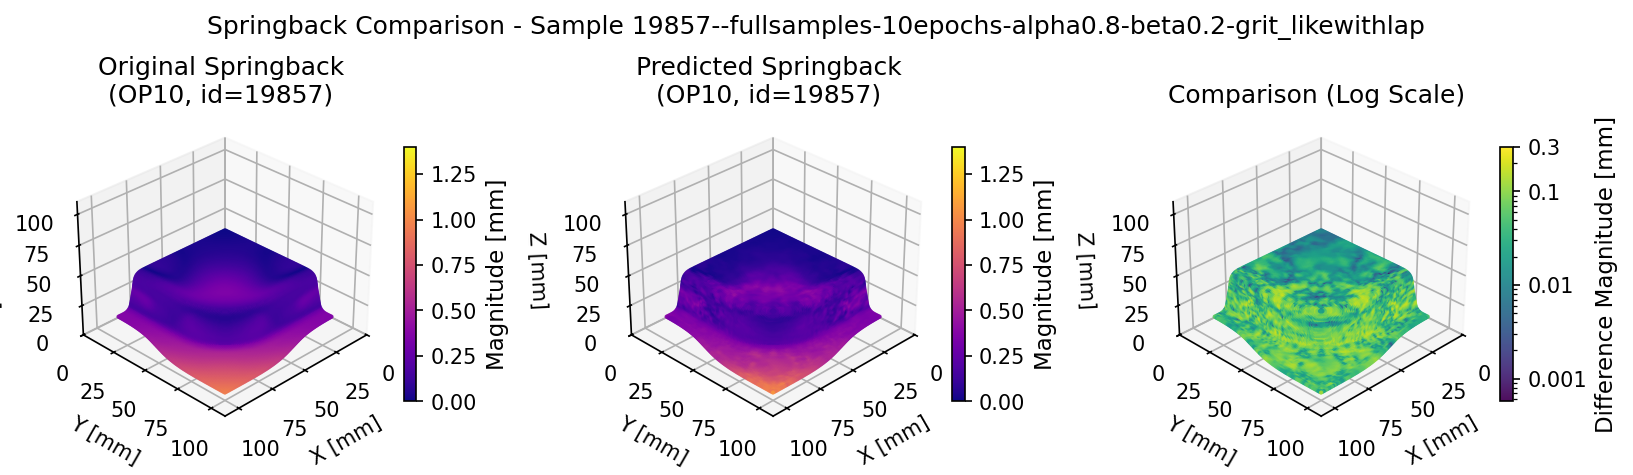

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, LogNorm  # <-- added LogNorm
from matplotlib import ticker
from matplotlib.ticker import LogFormatter, LogLocator  # for log colorbar ticks
from pathlib import Path
from DDACSDataset import DDACSDataset
from utils_DDACS import extract_mesh, extract_point_springback

# Config
OPERATION   = 10
TIMESTEP    = 2
sample_id   = "16039"
pred_dir    = "/home/RUS_CIP/st186731/research_project/hybrid_approach/grit_like_and_graphormer_like/prediction/ddacs-node-regression/grit_like"
# pred_dir    = "/home/RUS_CIP/st186731/research_project/hybrid_approach/grit_like_and_graphormer_like/prediction/ddacs-node-regression/graphormer_like"
data_root   = "/mnt/data/jiang"
data_dir    = Path("/mnt/data/darus/")

FIGURE_SIZES = {
    "double_col": (7.0, 3.0),
}
FIGURE_SIZE = FIGURE_SIZES["double_col"]
FIGURE_DPI = 150
AXIS_LIMITS = [0, 110]
VIEW_ELEVATION = 30
VIEW_AZIMUTH = 45

def find_h5_by_id(dataset, sid):
    """Return (sim_id, metadata, h5_path) for the given string/int sample id."""
    sid = str(sid)
    for i in range(len(dataset)):
        sim_id, meta, h5_path = dataset[i]
        if str(sim_id) == sid:
            return sim_id, meta, h5_path
    raise FileNotFoundError(f"Sample id {sid} not found in dataset")

def add_colorbar(fig, ax, mappable, label):
    cbar = fig.colorbar(mappable, ax=ax, shrink=0.8)
    # Auto formatting based on norm type
    if isinstance(mappable.norm, LogNorm):
        cbar.locator = LogLocator(base=10)
        cbar.formatter = LogFormatter(base=10, labelOnlyBase=False)
        cbar.update_ticks()
    else:
        cbar.ax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%.2f"))
    cbar.set_label(label, fontsize=11)

# Load dataset + files
dataset = DDACSDataset(data_dir, "h5")
print(f"Loaded {len(dataset)} simulations")

sim_id, metadata, h5_path = find_h5_by_id(dataset, sample_id)
print(f"Using sample {sim_id} → {h5_path}")
print(f"Metadata: {metadata}")

# Mesh
node_coords, triangles = extract_mesh(
    h5_path, operation=OPERATION, component='blank', timestep=TIMESTEP
)  # node_coords: (N,3)

# Original springback
final_coords_gt, disp_gt = extract_point_springback(h5_path, operation=OPERATION)

# Predicted springback
pred_path = os.path.join(pred_dir, f"{sample_id}_pred_node_displacement.npy")
disp_pred = np.load(pred_path)

# Compute magnitudes
mag_gt   = np.linalg.norm(disp_gt,   axis=1)  # [mm]
mag_pred = np.linalg.norm(disp_pred, axis=1)  # [mm]
difference_vector = disp_pred - disp_gt
difference_mag    = np.linalg.norm(difference_vector, axis=1)  # [mm] absolute L2 error per node

# Basic stats
print("\n--- Springback stats ---")
print(f"Ground_Truth : mean={mag_gt.mean():.4f},  max={mag_gt.max():.4f},  std={mag_gt.std():.4f}")
print(f"Prediction   : mean={mag_pred.mean():.4f}, max={mag_pred.max():.4f}, std={mag_pred.std():.4f}")
print(f"Difference   : mean={difference_mag.mean():.4f},  max={difference_mag.max():.4f},  std={difference_mag.std():.4f}")

# Coordinates to plot (use GT final pose for all panels for easy comparison)
coords_plot = node_coords + disp_gt

# Color normalization
global_springback_min = 0.0
global_springback_max = 1.4
norm_linear = Normalize(vmin=global_springback_min, vmax=global_springback_max)

# For the difference panel (log scale): vmin must be > 0
minimum_allowed_lower_bound = 1e-6
pos = difference_mag > 0
vmin_diff = max(minimum_allowed_lower_bound, difference_mag[pos].min())
global_springback_max_difference = 0.3
vmax_diff = global_springback_max_difference
norm_difference = LogNorm(vmin=vmin_diff, vmax=vmax_diff)

print(f"\n[LogNorm] vmin={global_springback_min_difference:.2f}, vmax={global_springback_max_difference:.2f}")

# Figure
fig = plt.figure(figsize=(FIGURE_SIZE[0]*1.6, FIGURE_SIZE[1]), dpi=FIGURE_DPI)

# Precompute colors for the linear panels (GT & Pred)
col1 = plt.cm.plasma(norm_linear(mag_gt))
col2 = plt.cm.plasma(norm_linear(mag_pred))

diff_for_plot = np.clip(difference_mag, vmin_diff, None)

def add_colorbar(fig, ax, mappable, label):
    cbar = fig.colorbar(mappable, ax=ax, shrink=0.8)
    if isinstance(mappable.norm, LogNorm):
        cbar.locator   = LogLocator(base=10, subs=(1.,))
        cbar.formatter = LogFormatter(base=10, labelOnlyBase=False)
        cbar.update_ticks()
    else:
        cbar.ax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%.2f"))
    cbar.set_label(label, fontsize=11)
    return cbar

# --- Panel 1: Original magnitude (linear) ---
ax1 = fig.add_subplot(131, projection="3d")
ax1.scatter(coords_plot[:,0], coords_plot[:,1], coords_plot[:,2], c=col1, s=1, alpha=0.9)
add_colorbar(fig, ax1, plt.cm.ScalarMappable(cmap="plasma", norm=norm_linear), "Magnitude [mm]")
ax1.set_title(f"Original Springback\n(OP{OPERATION}, id={sim_id})")
ax1.set_xlim(AXIS_LIMITS); ax1.set_ylim(AXIS_LIMITS); ax1.set_zlim(AXIS_LIMITS)
ax1.view_init(VIEW_ELEVATION, VIEW_AZIMUTH)
ax1.set_xlabel("X [mm]"); ax1.set_ylabel("Y [mm]"); ax1.set_zlabel("Z [mm]")

# --- Panel 2: Predicted magnitude (linear) ---
ax2 = fig.add_subplot(132, projection="3d")
ax2.scatter(coords_plot[:,0], coords_plot[:,1], coords_plot[:,2], c=col2, s=1, alpha=0.9)
add_colorbar(fig, ax2, plt.cm.ScalarMappable(cmap="plasma", norm=norm_linear), "Magnitude [mm]")
ax2.set_title(f"Predicted Springback\n(OP{OPERATION}, id={sim_id})")
ax2.set_xlim(AXIS_LIMITS); ax2.set_ylim(AXIS_LIMITS); ax2.set_zlim(AXIS_LIMITS)
ax2.view_init(VIEW_ELEVATION, VIEW_AZIMUTH)
ax2.set_xlabel("X [mm]"); ax2.set_ylabel("Y [mm]"); ax2.set_zlabel("Z [mm]")

# --- Panel 3: Difference ||pred - gt|| (LOG scale) ---
ax3 = fig.add_subplot(133, projection="3d")
sc3 = ax3.scatter(
    coords_plot[:, 0], coords_plot[:, 1], coords_plot[:, 2],
    c=diff_for_plot, cmap="viridis", norm=norm_difference,
    s=1, alpha=0.95
)

# Colorbar from the scatter mappable
cbar3 = fig.colorbar(sc3, ax=ax3, shrink=0.8)
#cbar3.ax.minorticks_off()                     # optional: hide minor ticks
cbar3.set_ticks([3e-1,1e-1, 1e-2, 1e-3,])                 # positions
cbar3.set_ticklabels(['0.3', '0.1','0.01', '0.001'])        # labels you want
cbar3.set_label("Difference Magnitude [mm]", fontsize=11)

ax3.set_title("Comparison (Log Scale)")
ax3.set_xlim(AXIS_LIMITS); ax3.set_ylim(AXIS_LIMITS); ax3.set_zlim(AXIS_LIMITS)
ax3.view_init(VIEW_ELEVATION, VIEW_AZIMUTH)
ax3.set_xlabel("X [mm]"); ax3.set_ylabel("Y [mm]"); ax3.set_zlabel("Z [mm]")

# plt.suptitle(f"Springback Comparison - Sample {sim_id}-fullsamples-10epochs-alpha0.8-beta0.2-grit_likewithlap", y=0.98, fontsize=12)
plt.suptitle(f"Springback Comparison - Sample {sim_id}--fullsamples-10epochs-alpha0.8-beta0.2-grit_likewithlap", y=0.98, fontsize=12)
# plt.suptitle(f"Springback Comparison - Sample {sim_id}", y=0.98, fontsize=12)

save_dir = Path("/home/RUS_CIP/st186731/research_project/figures")
save_dir.mkdir(parents=True, exist_ok=True)

fig.tight_layout()  # arrange subplots nicely
if pred_dir == "/home/RUS_CIP/st186731/research_project/hybrid_approach/grit_like_and_graphormer_like/prediction/ddacs-node-regression/graphormer_like":
    fig.savefig(save_dir / f"springback_id{sample_id}_graphormer_like_with_lap_loss.png",
                dpi=150, bbox_inches="tight", pad_inches=0.1)
else:
    fig.savefig(save_dir / f"springback_id{sample_id}_grit_like_without_lap_loss_logscale-fullsamples-10epochs-alpha0.8-beta0.2-grit_likewithlap.png",
                dpi=150, bbox_inches="tight", pad_inches=0.1)

plt.show()


Loaded 32071 simulations
Using sample 16039 → /mnt/data/darus/h5/16039.h5
Metadata: [1.0e+00 0.0e+00 0.0e+00 3.0e+01 9.0e-01 5.0e-02 9.5e-01 1.0e+05]

--- Springback stats ---
Ground_Truth : mean=0.2124,  max=0.7167,  std=0.1983
Prediction   : mean=0.2295, max=0.9434, std=0.2098
Difference(L2 per-node) : mean=0.0503,  max=0.2932,  std=0.0349

--- Chamfer stats (L2) ---
Forward (GT→Pred): mean=0.050312, max=0.293171, std=0.034948
Backward(Pred→GT): mean=0.050312, max=0.293171, std=0.034948
Symmetric        : 0.100624

[LogNorm] vmin=1.49e-03, vmax=0.30


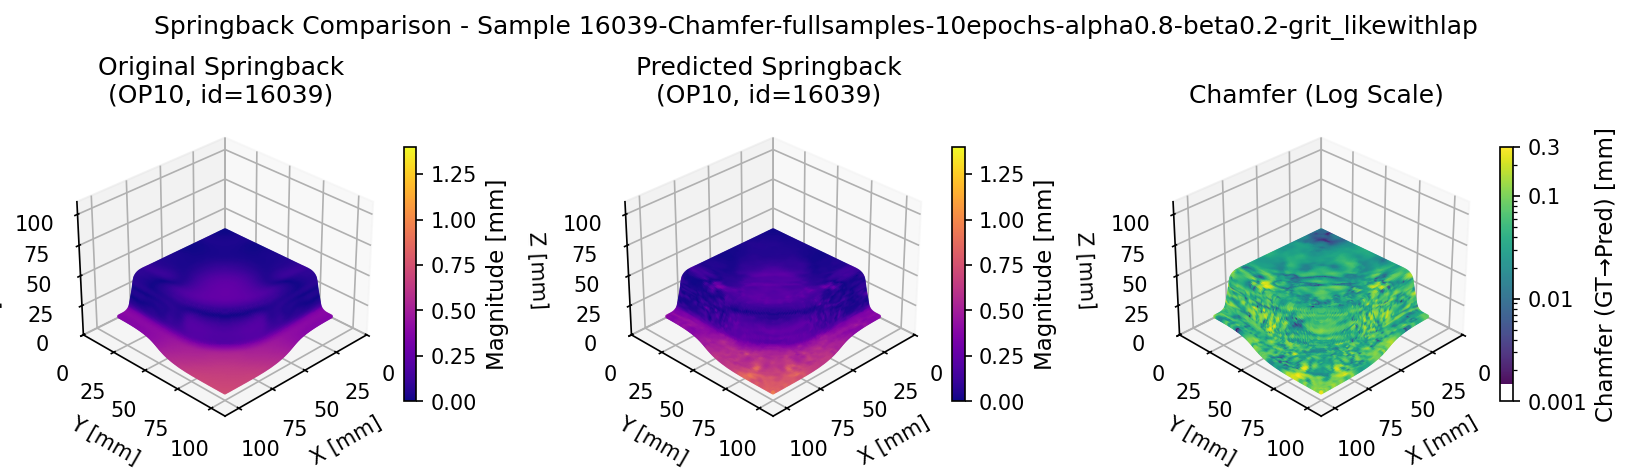

In [1]:
import os 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, LogNorm  
from matplotlib import ticker
from matplotlib.ticker import LogFormatter, LogLocator  # for log colorbar ticks
from pathlib import Path
from DDACSDataset import DDACSDataset
from utils_DDACS import extract_mesh, extract_point_springback

#  Config 
OPERATION   = 10
TIMESTEP    = 2
sample_id   = "16039"
pred_dir    = "/home/RUS_CIP/st186731/research_project/hybrid_approach/grit_like_and_graphormer_like/prediction/ddacs-node-regression/grit_like-fullsamples-10epochs-alpha0.8-beta0.2-grit_likewithlap"
# pred_dir  = "/home/RUS_CIP/st186731/research_project/hybrid_approach/grit_like_and_graphormer_like/prediction/ddacs-node-regression/graphormer_like"
data_root   = "/mnt/data/jiang"
data_dir    = Path("/mnt/data/darus/")

FIGURE_SIZES = {
    "double_col": (7.0, 3.0),
}
FIGURE_SIZE = FIGURE_SIZES["double_col"]
FIGURE_DPI = 150
AXIS_LIMITS = [0, 110]
VIEW_ELEVATION = 30
VIEW_AZIMUTH = 45

#  Utils 
def find_h5_by_id(dataset, sid):
    """Return (sim_id, metadata, h5_path) for the given string/int sample id."""
    sid = str(sid)
    for i in range(len(dataset)):
        sim_id, meta, h5_path = dataset[i]
        if str(sim_id) == sid:
            return sim_id, meta, h5_path
    raise FileNotFoundError(f"Sample id {sid} not found in dataset")

def add_colorbar(fig, ax, mappable, label):
    cbar = fig.colorbar(mappable, ax=ax, shrink=0.8)
    # Auto formatting based on norm type
    if isinstance(mappable.norm, LogNorm):
        cbar.locator = LogLocator(base=10)
        cbar.formatter = LogFormatter(base=10, labelOnlyBase=False)
        cbar.update_ticks()
    else:
        cbar.ax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%.2f"))
    cbar.set_label(label, fontsize=11)

#  Chamfer helpers (minimal, self-contained)

from scipy.spatial import cKDTree as KDTree


def _nearest_neighbor_distances_chunked(query_points, reference_points, query_chunk=1024, reference_chunk=4096):
    """
    Fallback NN distances: for each point in query_points, compute the distance
    to the nearest neighbor in reference_points using two-level chunking.
    Returns an array of shape (len(query_points),) with L2 distances.
    """
    n_q = query_points.shape[0]
    out = np.empty(n_q, dtype=np.float64)
    for i0 in range(0, n_q, query_chunk):
        i1 = min(i0 + query_chunk, n_q)
        q_blk = query_points[i0:i1]   # (m,3)
        # initialize current mins to +inf
        cur_min_sq = np.full(q_blk.shape[0], np.inf, dtype=np.float64)
        for j0 in range(0, reference_points.shape[0], reference_chunk):
            j1 = min(j0 + reference_chunk, reference_points.shape[0])
            r_blk = reference_points[j0:j1]  # (n,3)
            diff = q_blk[:, None, :] - r_blk[None, :, :]   # (m,n,3)
            d2 = np.sum(diff * diff, axis=2)               # (m,n)
            cur_min_sq = np.minimum(cur_min_sq, d2.min(axis=1))
        out[i0:i1] = np.sqrt(cur_min_sq)
    return out

def nearest_neighbor_distances(query_points, reference_points):
    """
    Per-point NN distances from query_points to reference_points (L2).
    Uses cKDTree if available, else a robust chunked NumPy fallback.
    """
    if KDTree is not None:
        tree = KDTree(reference_points)
        try:
            dists, _ = tree.query(query_points, k=1, workers=-1)
        except TypeError:
            dists, _ = tree.query(query_points, k=1)
        return dists.astype(np.float64)
    return _nearest_neighbor_distances_chunked(query_points, reference_points)

# -------------------- Load dataset + files --------------------
dataset = DDACSDataset(data_dir, "h5")
print(f"Loaded {len(dataset)} simulations")

sim_id, metadata, h5_path = find_h5_by_id(dataset, sample_id)
print(f"Using sample {sim_id} → {h5_path}")
print(f"Metadata: {metadata}")

# Mesh
node_coords, triangles = extract_mesh(
    h5_path, operation=OPERATION, component='blank', timestep=TIMESTEP
)  # node_coords: (N,3)

# Original springback
final_coords_gt, disp_gt = extract_point_springback(h5_path, operation=OPERATION)

# Predicted springback
pred_path = os.path.join(pred_dir, f"{sample_id}_pred_node_displacement.npy")
disp_pred = np.load(pred_path)

# Compute magnitudes
mag_gt   = np.linalg.norm(disp_gt,   axis=1)  # [mm]
mag_pred = np.linalg.norm(disp_pred, axis=1)  # [mm]
difference_vector = disp_pred - disp_gt
difference_mag    = np.linalg.norm(difference_vector, axis=1)  # [mm] absolute L2 error per node

# --------- Chamfer distances (GT↔Pred final positions) ---------
final_coords_pred = node_coords + disp_pred           # predicted final pose
# Forward (GT→Pred) and Backward (Pred→GT)
chamfer_forward  = nearest_neighbor_distances(final_coords_gt,  final_coords_pred)
chamfer_backward = nearest_neighbor_distances(final_coords_pred, final_coords_gt)
chamfer_symmetric = chamfer_forward.mean() + chamfer_backward.mean()

# Basic stats
print("\n--- Springback stats ---")
print(f"Ground_Truth : mean={mag_gt.mean():.4f},  max={mag_gt.max():.4f},  std={mag_gt.std():.4f}")
print(f"Prediction   : mean={mag_pred.mean():.4f}, max={mag_pred.max():.4f}, std={mag_pred.std():.4f}")
print(f"Difference(L2 per-node) : mean={difference_mag.mean():.4f},  max={difference_mag.max():.4f},  std={difference_mag.std():.4f}")

print("\n--- Chamfer stats (L2) ---")
print(f"Forward (GT→Pred): mean={chamfer_forward.mean():.6f}, max={chamfer_forward.max():.6f}, std={chamfer_forward.std():.6f}")
print(f"Backward(Pred→GT): mean={chamfer_backward.mean():.6f}, max={chamfer_backward.max():.6f}, std={chamfer_backward.std():.6f}")
print(f"Symmetric        : {chamfer_symmetric:.6f}")

# Coordinates to plot (use GT final pose for all panels for easy comparison)
coords_plot = node_coords + disp_gt

# Color normalization
global_springback_min = 0.0
global_springback_max = 1.4
norm_linear = Normalize(vmin=global_springback_min, vmax=global_springback_max)

# For the difference panel (log scale): use Chamfer forward (GT→Pred)
per_point_difference = chamfer_forward
minimum_allowed_lower_bound = 1e-6
pos_mask = per_point_difference > 0
vmin_diff = max(minimum_allowed_lower_bound, per_point_difference[pos_mask].min() if np.any(pos_mask) else minimum_allowed_lower_bound)
global_springback_max_difference = 0.3
vmax_diff = global_springback_max_difference
norm_difference = LogNorm(vmin=vmin_diff, vmax=vmax_diff)

print(f"\n[LogNorm] vmin={vmin_diff:.2e}, vmax={global_springback_max_difference:.2f}")

# Figure
fig = plt.figure(figsize=(FIGURE_SIZE[0]*1.6, FIGURE_SIZE[1]), dpi=FIGURE_DPI)

# Precompute colors for the linear panels (GT & Pred)
col1 = plt.cm.plasma(norm_linear(mag_gt))
col2 = plt.cm.plasma(norm_linear(mag_pred))

diff_for_plot = np.clip(per_point_difference, vmin_diff, None)

# (re)define add_colorbar with LogNorm subs for this figure
def add_colorbar(fig, ax, mappable, label):
    cbar = fig.colorbar(mappable, ax=ax, shrink=0.8)
    if isinstance(mappable.norm, LogNorm):
        cbar.locator   = LogLocator(base=10, subs=(1.,))
        cbar.formatter = LogFormatter(base=10, labelOnlyBase=False)
        cbar.update_ticks()
    else:
        cbar.ax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%.2f"))
    cbar.set_label(label, fontsize=11)
    return cbar

# --- Panel 1: Original magnitude (linear) ---
ax1 = fig.add_subplot(131, projection="3d")
ax1.scatter(coords_plot[:,0], coords_plot[:,1], coords_plot[:,2], c=col1, s=1, alpha=0.9)
add_colorbar(fig, ax1, plt.cm.ScalarMappable(cmap="plasma", norm=norm_linear), "Magnitude [mm]")
ax1.set_title(f"Original Springback\n(OP{OPERATION}, id={sim_id})")
ax1.set_xlim(AXIS_LIMITS); ax1.set_ylim(AXIS_LIMITS); ax1.set_zlim(AXIS_LIMITS)
ax1.view_init(VIEW_ELEVATION, VIEW_AZIMUTH)
ax1.set_xlabel("X [mm]"); ax1.set_ylabel("Y [mm]"); ax1.set_zlabel("Z [mm]")

# --- Panel 2: Predicted magnitude (linear) ---
ax2 = fig.add_subplot(132, projection="3d")
ax2.scatter(coords_plot[:,0], coords_plot[:,1], coords_plot[:,2], c=col2, s=1, alpha=0.9)
add_colorbar(fig, ax2, plt.cm.ScalarMappable(cmap="plasma", norm=norm_linear), "Magnitude [mm]")
ax2.set_title(f"Predicted Springback\n(OP{OPERATION}, id={sim_id})")
ax2.set_xlim(AXIS_LIMITS); ax2.set_ylim(AXIS_LIMITS); ax2.set_zlim(AXIS_LIMITS)
ax2.view_init(VIEW_ELEVATION, VIEW_AZIMUTH)
ax2.set_xlabel("X [mm]"); ax2.set_ylabel("Y [mm]"); ax2.set_zlabel("Z [mm]")

# --- Panel 3: Chamfer ||GT→Pred|| (LOG scale) ---
ax3 = fig.add_subplot(133, projection="3d")
sc3 = ax3.scatter(
    coords_plot[:, 0], coords_plot[:, 1], coords_plot[:, 2],
    c=diff_for_plot, cmap="viridis", norm=norm_difference,
    s=1, alpha=0.95
)

# Colorbar from the scatter mappable
cbar3 = fig.colorbar(sc3, ax=ax3, shrink=0.8)
cbar3.set_ticks([3e-1, 1e-1, 1e-2, 1e-3])
cbar3.set_ticklabels(['0.3', '0.1', '0.01', '0.001'])
cbar3.set_label("Chamfer (GT→Pred) [mm]", fontsize=11)

ax3.set_title("Chamfer (Log Scale)")
ax3.set_xlim(AXIS_LIMITS); ax3.set_ylim(AXIS_LIMITS); ax3.set_zlim(AXIS_LIMITS)
ax3.view_init(VIEW_ELEVATION, VIEW_AZIMUTH)
ax3.set_xlabel("X [mm]"); ax3.set_ylabel("Y [mm]"); ax3.set_zlabel("Z [mm]")

plt.suptitle(f"Springback Comparison - Sample {sim_id}-Chamfer-fullsamples-10epochs-alpha0.8-beta0.2-grit_likewithlap", y=0.98, fontsize=12)

save_dir = Path("/home/RUS_CIP/st186731/research_project/figures")
save_dir.mkdir(parents=True, exist_ok=True)

fig.tight_layout()  # arrange subplots nicely
if pred_dir == "/home/RUS_CIP/st186731/research_project/hybrid_approach/grit_like_and_graphormer_like/prediction/ddacs-node-regression/graphormer_like":
    fig.savefig(save_dir / f"springback_id{sample_id}_graphormer_like_with_lap_loss_chamfer.png",
                dpi=150, bbox_inches="tight", pad_inches=0.1)
else:
    fig.savefig(save_dir / f"springback_id{sample_id}_grit_like_chamfer-fullsamples-10epochs-alpha0.8-beta0.2-grit_likewithlap.png",
                dpi=150, bbox_inches="tight", pad_inches=0.1)

plt.show()
